# Проект моделирования температуры стали в ковше с целью оптимизации потребления электроэнергии.

### Задача

Чтобы оптимизировать производственные расходы, металлургический комбинат решил уменьшить потребление электроэнергии на этапе обработки стали. Необходимо построить модель, которая предскажет температуру стали.

### Описание технологического процесса

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша.

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

### Описание данных:
Данные состоят из файлов, полученных из разных источников:
* data_arc.csv — данные об электродах;
* data_bulk.csv — данные о подаче сыпучих материалов (объём);
* data_bulk_time.csv — данные о подаче сыпучих материалов (время);
* data_gas.csv — данные о продувке сплава газом;
* data_temp.csv — результаты измерения температуры;
* data_wire.csv — данные о проволочных материалах (объём);
* data_wire_time.csv — данные о проволочных материалах (время).

Во всех файлах столбец key содержит номер партии. В файлах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.

Обьект моделирования - один ковш (один процесс варки), который определяется уникальным ключом key.

### Условия задачи:

* Целевой признак: последняя температура для уникальной партии;
* Целевая метрика: MAE;
* Критерий успешности: получение метрики MAE < 6.8;
* Использовать как признак можно только первую температуру, исследованную до процесса;
* В случае некорректных данных (один замер; значение, противоречащее здравому смыслу) данные считаем непригодными для всей партии, к которой относятся эти данные.

### План работы:

* Загрузка данных;
* Исследовательский анализ данных;
* Предобработка данных;
* Разработка и выбор лучшей модели с последующей проверкой на тестовой выборке;
* Отчет.

## 1. Загрузка данных

In [3]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 11.4 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
import lightgbm as lgb
from sklearn.dummy import DummyRegressor

from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_absolute_error

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#для использования в random_state во всей работе
SEED = 220523

In [6]:
path_list = ['/content/drive/My Drive/projects/metals_plant_steel_temperature_prediction/data_arc_new.csv',
             '/content/drive/My Drive/projects/metals_plant_steel_temperature_prediction/data_bulk_new.csv',
             '/content/drive/My Drive/projects/metals_plant_steel_temperature_prediction/data_bulk_time_new.csv',
             '/content/drive/My Drive/projects/metals_plant_steel_temperature_prediction/data_gas_new.csv',
             '/content/drive/My Drive/projects/metals_plant_steel_temperature_prediction/data_temp_new.csv',
             '/content/drive/My Drive/projects/metals_plant_steel_temperature_prediction/data_wire_new.csv',
             '/content/drive/My Drive/projects/metals_plant_steel_temperature_prediction/data_wire_time_new.csv']

df_dict = {}

for i, path in enumerate(path_list):
    try:
        df_name = path.\
                  replace('/content/drive/My Drive/projects/metals_plant_steel_temperature_prediction/data_', '').\
                  replace('_new.csv', '')
        df_dict[df_name] = pd.read_csv(path)
        print(f'DataFrame {df_name} downloaded successfully!')
    except:
        print(f'An error occurred while downloading the DataFrame {df_name}')

DataFrame arc downloaded successfully!
DataFrame bulk downloaded successfully!
DataFrame bulk_time downloaded successfully!
DataFrame gas downloaded successfully!
DataFrame temp downloaded successfully!
DataFrame wire downloaded successfully!
DataFrame wire_time downloaded successfully!


In [7]:
for key, df in df_dict.items():
    print(f"Shape of DataFrame '{key}' is {df.shape} \n")

Shape of DataFrame 'arc' is (14876, 5) 

Shape of DataFrame 'bulk' is (3129, 16) 

Shape of DataFrame 'bulk_time' is (3129, 16) 

Shape of DataFrame 'gas' is (3239, 2) 

Shape of DataFrame 'temp' is (18092, 3) 

Shape of DataFrame 'wire' is (3081, 10) 

Shape of DataFrame 'wire_time' is (3081, 10) 



## 2. Исследовательский анализ данных

**Для проведения первичного исследовательского анализа данных каждого из имеющихся датафреймов выведем информацию по каждому из них.**

### 2.1 Данные об электродах

In [ ]:
# Напишем функцию, которая будет выводить кол-во пропусков в долях и остальную инф-цию
def info_func(dataframe, name):
    key = name
    df = dataframe.copy()
    null_shares = df.isnull().sum() / len(df)
    total_objects = len(df)
    column_types = df.dtypes
    info_df = pd.DataFrame({'Null%': null_shares, \
                            'Total': total_objects, \
                            'Total_Null': df.isnull().sum(), \
                            'Type': column_types})
    print(f'Кол-во пропусков в долях в датафрейме "{key}" \n\n{info_df}\n\n')
    print(f'Первые 5 строк в датафрейме "{key}" \n \n {df.head()} \n\n')
    print(f'Описание распределения в датафрейме "{key}" \n\n{df.describe()}\n\n')
    print(f'Кол-во полных дубликатов в датафрейме "{key}" = {df.duplicated().sum()}')
    return

info_func(df_dict['arc'], 'arc')

Кол-во пропусков в долях в датафрейме "arc" 

                      Null%  Total  Total_Null     Type
key                     0.0  14876           0    int64
Начало нагрева дугой    0.0  14876           0   object
Конец нагрева дугой     0.0  14876           0   object
Активная мощность       0.0  14876           0  float64
Реактивная мощность     0.0  14876           0  float64


Первые 5 строк в датафрейме "arc" 
 
    key Начало нагрева дугой  Конец нагрева дугой  Активная мощность  \
0    1  2019-05-03 11:02:14  2019-05-03 11:06:02           0.305130   
1    1  2019-05-03 11:07:28  2019-05-03 11:10:33           0.765658   
2    1  2019-05-03 11:11:44  2019-05-03 11:14:36           0.580313   
3    1  2019-05-03 11:18:14  2019-05-03 11:24:19           0.518496   
4    1  2019-05-03 11:26:09  2019-05-03 11:28:37           0.867133   

   Реактивная мощность  
0             0.211253  
1             0.477438  
2             0.430460  
3             0.379979  
4             0.643691   


**Видим, что максимальное значение номера партии равно 3241. Проверим, действительно ли в данных этого датафрейма представлены все номера партии от 1 до 3241.**

In [ ]:
len(df_dict['arc']['key'].unique())

3214

**Длина уникальных значений номеров партии не равна 3241, значит, не все номера партии представлены в этом датафрейме. Проверим, какие из них отсутствуют.**

In [ ]:
keys_not_in_arc = [x for x in list(range(1, 3242)) if x not in df_dict['arc']['key'].values]
print(f'Номера партий, отсутствующих в данных датафрейма "arc": {keys_not_in_arc}')
print(f'Количество партий, отсутствующих в данных датафрейма "arc": {len(keys_not_in_arc)}')

Номера партий, отсутствующих в данных датафрейма "arc": [41, 42, 195, 279, 355, 382, 506, 529, 540, 607, 683, 710, 766, 1133, 1300, 1437, 2031, 2103, 2278, 2356, 2373, 2446, 2469, 2491, 2683, 3200, 3207]
Количество партий, отсутствующих в данных датафрейма "arc": 27


**Пропуски в данных отсутствуют. Из аномального - наблюдаются отрицательные значения в переменной Реактивная мощность. Вероятнее всего, это связано с ошибкой измерения или вычисления, если данный параметр вычисляется внутри АСУ ТП.**

**Необходимо будет впоследствии изменить тип признаков "Начало нагрева дугой" и "Конец нагрева дугой" на datetime, т.к. данные признаки отвечают за дату и время.**

**Кроме того, для удобства работы название признаков необходимо привести к англ. названию и "змеиному" регистру, это касается всех датафреймов, где применимо.**

**Т.к. в данном проекте мы не будем использовать временные ряды, то значения времени будут впоследствии нами удалены. Однако, в данном датафрейме мы можем воспользоваться значениями времени для генерировании нового признака, тем самым не потерять их и учесть. Можно вычислить значение затраченной энергии как произведение мощности на время, в течение которого данная мощность выделялась для каждой партии.**

**Фактически, активная мощность определяет скорость полезного потребления энергии. Реактивная мощность — мощность определяемая электромагнитными полями, образующимися в процессе работы оборудования. Реактивная мощность, как правило, является «вредной» или «паразитной». Реактивная мощность определяется характером нагрузки. Поэтому для генерирования нового признака будем использовать энергию, вычисляемую только на основе активной мощности.**

**Также для каждой уникальной партии необходимо будет рассчитать в качестве нового признака суммарную потребленную мощность как активную, так и реактивную.**

**Посмотрим, какое кол-во партий имеет аномальные значения реактивной мощности.**

In [ ]:
df_dict['arc'][df_dict['arc']['Реактивная мощность'] <= 0]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924


In [ ]:
keys_anomaly_power = list(df_dict['arc'][df_dict['arc']['Реактивная мощность'] <= 0]['key'].unique())
keys_anomaly_power

[2116]

**Добавим номер этой партии в отдельный список, где будем хранить номера партии, которые следует удалить из агреггированного датафрейма впоследствие.**

In [ ]:
keys_to_del = []
keys_to_del.extend(keys_anomaly_power)
keys_to_del

[2116]

**Посмотрим на распределение замеров мощности среди всех партий.**

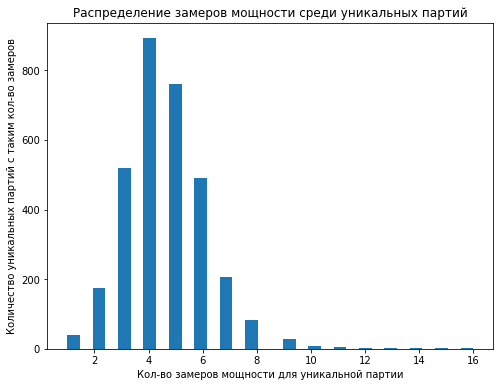

In [ ]:
plt.figure(figsize=(8, 6))
plt.hist(df_dict['arc']['key'].value_counts(), bins=32)
plt.xlabel('Кол-во замеров мощности для уникальной партии')
plt.ylabel('Количество уникальных партий с таким кол-во замеров')
plt.title('Распределение замеров мощности среди уникальных партий')
plt.show()

**Видим, что наибольшее кол-во партий имеют среди всех данных по 4 замера мощности.**

**Посмотрим на распределение значений реактивной и активной мощности, при этом из значений реактивной исключим аномальное отрицательное значение, чтобы получить читабельный график.**

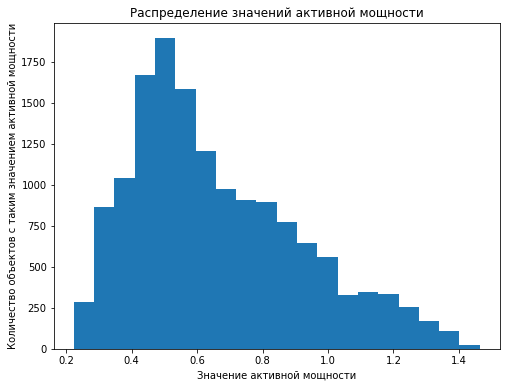

In [ ]:
plt.figure(figsize=(8, 6))
plt.hist(df_dict['arc']['Активная мощность'], bins=20)
plt.xlabel('Значение активной мощности')
plt.ylabel('Количество объектов с таким значением активной мощности')
plt.title('Распределение значений активной мощности')
plt.show()

**Значения активной мощности распределены нормально, чаще всего встречается значение 0.5.**

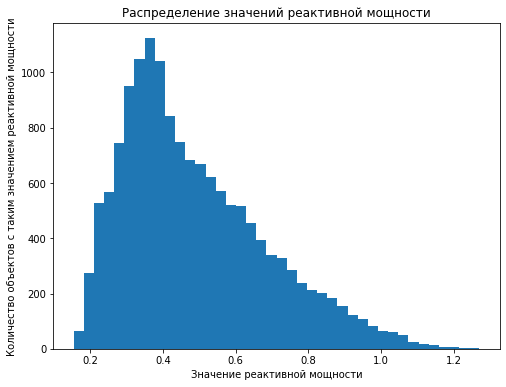

In [ ]:
plt.figure(figsize=(8, 6))
plt.hist(df_dict['arc']['Реактивная мощность'][df_dict['arc']['Реактивная мощность'] > 0], bins=40)
plt.xlabel('Значение реактивной мощности')
plt.ylabel('Количество объектов с таким значением реактивной мощности')
plt.title('Распределение значений реактивной мощности')
plt.show()

**Значения реактивной мощности (исключая аномальное отрицательное значение) распределены нормально, чаще всего встречается значение менее 0.4.**

**Промежуточные выводы по данным в датафрейме 'arc', содержащем данные об электродах.**

* В данных этого датафрейма пропусков нет.
* В данных по электродам всего одна партия с аномальным значением реактивной мощности -  партия 2116.
* Чаще всего в данных встречается по 4 замера мощности для каждой уникальной партии.
* Значения активной мощности нормально распределены с пиком в значении 0.5.
* Значения реактивной мощности нормально распределены (исключая аномальное отрицательное значение) с пиком в значении чуть ниже 0.4.
* Количество партий 3241, но они не все представлены в этом датафрейме, нет данных о 27 уникальных партиях.
* Из значений активной мощности и дельты времени можно получить новый признак - суммарную активную энергию для уникальной партии.
* Из значений активной и реактивной мощности с помощью суммы для одной уникальной партии можно получить новые признаки - суммарную потребленную активную и реактивную  мощность для данной партии.
* Необходимо привести названия признаков к "змеиному" регистру и на англ.
* Необходимо изменить тип двух признаков "Начало нагрева дугой" и "Конец нагрева дугой" на datetime, т.к. они отвечают за дату и время.

### 2.2 Данные о подаче сыпучих материалов (объём)

In [ ]:
info_func(df_dict['bulk'], 'bulk')

Кол-во пропусков в долях в датафрейме "bulk" 

            Null%  Total  Total_Null     Type
key      0.000000   3129           0    int64
Bulk 1   0.919463   3129        2877  float64
Bulk 2   0.992969   3129        3107  float64
Bulk 3   0.585171   3129        1831  float64
Bulk 4   0.675935   3129        2115  float64
Bulk 5   0.975391   3129        3052  float64
Bulk 6   0.815916   3129        2553  float64
Bulk 7   0.992010   3129        3104  float64
Bulk 8   0.999680   3129        3128  float64
Bulk 9   0.993928   3129        3110  float64
Bulk 10  0.943752   3129        2953  float64
Bulk 11  0.943432   3129        2952  float64
Bulk 12  0.217002   3129         679  float64
Bulk 13  0.994247   3129        3111  float64
Bulk 14  0.103228   3129         323  float64
Bulk 15  0.281560   3129         881  float64


Первые 5 строк в датафрейме "bulk" 
 
    key  Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  \
0    1     NaN     NaN     NaN    43.0     NaN     NaN  

**Визуализируем кол-во действительных объектов в каждом из признаков**

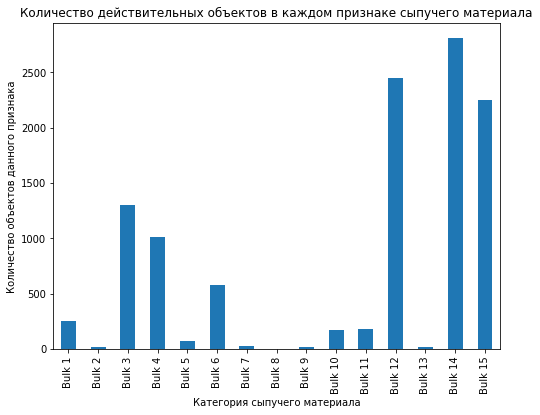

In [ ]:
plt.figure(figsize=(8, 6))
ax = df_dict['bulk'].drop('key', axis=1).notnull().sum().plot(kind='bar')
ax.set_title('Количество действительных объектов в каждом признаке сыпучего материала')
ax.set_xlabel('Категория сыпучего материала')
ax.set_ylabel('Количество объектов данного признака')
plt.show()

In [ ]:
bulks_to_del = df_dict['bulk'].drop('key', axis=1) \
                    .notnull().sum().sort_values() \
                    .iloc[0:5].index.to_list()
print(f'Список категорий сыпучих материалов для последующего удаления: \n{bulks_to_del}')

Список категорий сыпучих материалов для последующего удаления: 
['Bulk 8', 'Bulk 13', 'Bulk 9', 'Bulk 2', 'Bulk 7']


**Видим, что кол-во действительных объектов очень мало в категориях 2, 7, 8, 9, 13. Вероятнее всего для получения лучших результатов при моделировании необходимо будет исключить данные признаки в следующем разделе.**

**В данных этого датафрейма наблюдается очень большое количество пропусков, вероятнее всего данный факт может быть обусловлен спецификой технологического процесса, т.к. не для всех партий добавляются все типы сыпучих материалов. По этой причине логичнее всего пропуски в этих данных заполнить нулём. Сделаем это на следующем этапе предобработки данных.**

**Посмотрим на распределение данных в этом датафрейме по уникальным значениям номеров партий.**

In [ ]:
df_dict['bulk']['key'].value_counts().unique()

array([1])

**Для каждой партии встречается всего одна строка данных.**

**Из предыдущего подраздела мы знаем, что кол-во уникальных партий равно как минимум 3241, а в данном датафрейме мы видим, что кол-во партий - 3129. Узнаем, какие партии отсутствуют
в этом датафрейме.**

In [ ]:
keys_not_in_bulk = [x for x in list(range(1, 3242)) if x not in df_dict['bulk']['key'].values]
print(f'Номера партий, отсутствующих в данных датафрейма "bulk": {keys_not_in_bulk}')
print(f'Количество партий, отсутствующих в данных датафрейма "bulk": {len(keys_not_in_bulk)}')

Номера партий, отсутствующих в данных датафрейма "bulk": [41, 42, 51, 52, 53, 54, 55, 56, 72, 80, 81, 110, 151, 188, 195, 225, 269, 302, 330, 331, 332, 343, 350, 355, 382, 506, 529, 540, 607, 661, 683, 710, 766, 830, 874, 931, 933, 934, 960, 961, 964, 966, 983, 984, 1062, 1105, 1133, 1221, 1268, 1300, 1334, 1402, 1437, 1517, 1518, 1535, 1566, 1623, 1656, 1783, 1818, 1911, 1959, 1974, 1979, 2009, 2010, 2031, 2043, 2056, 2103, 2195, 2196, 2197, 2198, 2216, 2217, 2231, 2278, 2310, 2356, 2373, 2390, 2408, 2434, 2446, 2460, 2468, 2469, 2471, 2491, 2595, 2599, 2600, 2608, 2625, 2628, 2683, 2738, 2739, 2816, 2821, 2863, 2884, 2891, 3018, 3026, 3047, 3182, 3200, 3207, 3216]
Количество партий, отсутствующих в данных датафрейма "bulk": 112


**Промежуточные выводы по данным в датафрейме 'bulk', содержащем данные о подаче сыпучих материалов (объём).**

* В данных встречается только один набор значений для каждой уникальной партии.
* В этом датафрейме нет данных о 112 уникальных партиях.
* Необходимо привести названия признаков к "змеиному" регистру.
* В данных этого датафрейма наблюдается очень большое количество пропусков, вероятнее всего данный факт может быть обусловлен спецификой технологического процесса, логичнее всего пропуски в этих данных заполнить далее нулём.
* Кол-во действительных объектов очень мало в категориях 2, 7, 8, 9, 13 сыпучих материалов. Вероятнее всего для получения лучших результатов при моделировании необходимо будет исключить данные признаки в следующем разделе.

### 2.3 Данные о подаче сыпучих материалов (время)

In [ ]:
info_func(df_dict['bulk_time'], 'bulk_time')

Кол-во пропусков в долях в датафрейме "bulk_time" 

            Null%  Total  Total_Null    Type
key      0.000000   3129           0   int64
Bulk 1   0.919463   3129        2877  object
Bulk 2   0.992969   3129        3107  object
Bulk 3   0.585171   3129        1831  object
Bulk 4   0.675935   3129        2115  object
Bulk 5   0.975391   3129        3052  object
Bulk 6   0.815916   3129        2553  object
Bulk 7   0.992010   3129        3104  object
Bulk 8   0.999680   3129        3128  object
Bulk 9   0.993928   3129        3110  object
Bulk 10  0.943752   3129        2953  object
Bulk 11  0.943432   3129        2952  object
Bulk 12  0.217002   3129         679  object
Bulk 13  0.994247   3129        3111  object
Bulk 14  0.103228   3129         323  object
Bulk 15  0.281560   3129         881  object


Первые 5 строк в датафрейме "bulk_time" 
 
    key Bulk 1 Bulk 2 Bulk 3               Bulk 4 Bulk 5 Bulk 6 Bulk 7 Bulk 8  \
0    1    NaN    NaN    NaN  2019-05-03 11:28:48    NaN  

**В данных этого датафрейма наблюдается очень большое количество пропусков, аналогично предыдущему датафрейму.**

**Необходимо изменить тип данных на datetime, т.к. все данные признаки кроме значения номера партии отвечают за время и дату.**

**Необходимо привести к "змеиному" регистру названия признаков.**

**Посмотрим на распределение данных в этом датафрейме по уникальным значениям номеров партий.**

In [ ]:
df_dict['bulk_time']['key'].value_counts().unique()

array([1])

**Для каждой партии встречается всего одна строка данных.**

**Из предыдущего подраздела мы знаем, что кол-во уникальных партий равно как минимум 3241, а в данном датафрейме мы видим, что кол-во партий - 3129. Узнаем, какие партии отсутствуют
в этом датафрейме.**

In [ ]:
keys_not_in_bulk_time = [x for x in list(range(1, 3242)) if x not in df_dict['bulk_time']['key'].values]
print(f'Номера партий, отсутствующих в данных датафрейма "bulk_time": {keys_not_in_bulk_time}')
print(f'Количество партий, отсутствующих в данных датафрейма "bulk_time": {len(keys_not_in_bulk_time)}')

Номера партий, отсутствующих в данных датафрейма "bulk_time": [41, 42, 51, 52, 53, 54, 55, 56, 72, 80, 81, 110, 151, 188, 195, 225, 269, 302, 330, 331, 332, 343, 350, 355, 382, 506, 529, 540, 607, 661, 683, 710, 766, 830, 874, 931, 933, 934, 960, 961, 964, 966, 983, 984, 1062, 1105, 1133, 1221, 1268, 1300, 1334, 1402, 1437, 1517, 1518, 1535, 1566, 1623, 1656, 1783, 1818, 1911, 1959, 1974, 1979, 2009, 2010, 2031, 2043, 2056, 2103, 2195, 2196, 2197, 2198, 2216, 2217, 2231, 2278, 2310, 2356, 2373, 2390, 2408, 2434, 2446, 2460, 2468, 2469, 2471, 2491, 2595, 2599, 2600, 2608, 2625, 2628, 2683, 2738, 2739, 2816, 2821, 2863, 2884, 2891, 3018, 3026, 3047, 3182, 3200, 3207, 3216]
Количество партий, отсутствующих в данных датафрейма "bulk_time": 112


**Промежуточные выводы по данным в датафрейме 'bulk_time', содержащем данные о подаче сыпучих материалов (время).**

* В данных встречается только один набор значений для каждой уникальной партии.
* В этом датафрейме нет данных о 112 уникальных партиях.
* Привести тип признаков, отвечающих за дату и время (все кроме key) к datetime.
* Необходимо привести названия признаков к "змеиному" регистру.
* В данных этого датафрейма наблюдается очень большое количество пропусков, вероятнее всего данный факт может быть обусловлен спецификой технологического процесса, логичнее всего пропуски в этих данных заполнить далее нулём, если будет принятно решение использовать эти данные.

### 2.4 Данные о продувке сплава газом

In [ ]:
info_func(df_dict['gas'], 'gas')

Кол-во пропусков в долях в датафрейме "gas" 

       Null%  Total  Total_Null     Type
key      0.0   3239           0    int64
Газ 1    0.0   3239           0  float64


Первые 5 строк в датафрейме "gas" 
 
    key      Газ 1
0    1  29.749986
1    2  12.555561
2    3  28.554793
3    4  18.841219
4    5   5.413692 


Описание распределения в датафрейме "gas" 

               key        Газ 1
count  3239.000000  3239.000000
mean   1621.861377    11.002062
std     935.386334     6.220327
min       1.000000     0.008399
25%     812.500000     7.043089
50%    1622.000000     9.836267
75%    2431.500000    13.769915
max    3241.000000    77.995040


Кол-во полных дубликатов в датафрейме "gas" = 0


**Пропуски в данных отсутствуют.**

**Посмотрим на распределение данных в этом датафрейме по уникальным значениям номеров партий.**

In [ ]:
df_dict['gas']['key'].value_counts().unique()

array([1])

**Для каждой партии встречается всего одна строка данных.**

**Из предыдущего подраздела мы знаем, что кол-во уникальных партий равно как минимум 3241, а в данном датафрейме мы видим, что кол-во партий - 3129. Узнаем, какие партии отсутствуют
в этом датафрейме.**

In [ ]:
keys_not_in_gas = [x for x in list(range(1, 3242)) if x not in df_dict['gas']['key'].values]
print(f'Номера партий, отсутствующих в данных датафрейма "gas": {keys_not_in_gas}')
print(f'Количество партий, отсутствующих в данных датафрейма "gas": {len(keys_not_in_gas)}')

Номера партий, отсутствующих в данных датафрейма "gas": [193, 259]
Количество партий, отсутствующих в данных датафрейма "gas": 2


**Посмотрим распределение объема продувающего газа в датафрейме.**

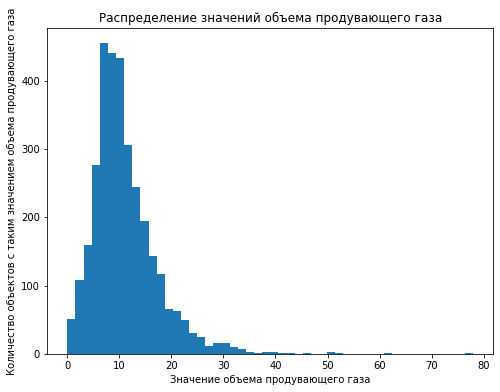

In [ ]:
plt.figure(figsize=(8, 6))
plt.hist(df_dict['gas']['Газ 1'], bins=50)
plt.xlabel('Значение объема продувающего газа')
plt.ylabel('Количество объектов с таким значением объема продувающего газа')
plt.title('Распределение значений объема продувающего газа')
plt.show()

**Видим нормальное распределение значений с пиком у значения 10.**

**Промежуточные выводы по данным в датафрейме 'gas', содержащем данные о продувке сплава газом.**

* В данных встречается только один набор значений для каждой уникальной партии.
* В этом датафрейме нет данных о 2 уникальных партиях.
* Распределение значений объема газа нормальное с пиком у значения 10.
* Необходимо привести название признака к "змеиному" регистру на англ.
* В данных этого датафрейма пропусков нет.

### 2.5 Данные о результатах измерения температуры

In [ ]:
info_func(df_dict['temp'], 'temp')

Кол-во пропусков в долях в датафрейме "temp" 

                 Null%  Total  Total_Null     Type
key           0.000000  18092           0    int64
Время замера  0.000000  18092           0   object
Температура   0.189421  18092        3427  float64


Первые 5 строк в датафрейме "temp" 
 
    key         Время замера  Температура
0    1  2019-05-03 11:02:04       1571.0
1    1  2019-05-03 11:07:18       1604.0
2    1  2019-05-03 11:11:34       1618.0
3    1  2019-05-03 11:18:04       1601.0
4    1  2019-05-03 11:25:59       1606.0 


Описание распределения в датафрейме "temp" 

                key   Температура
count  18092.000000  14665.000000
mean    1616.460977   1590.722741
std      934.641385     20.394381
min        1.000000   1191.000000
25%      807.750000   1580.000000
50%     1618.000000   1590.000000
75%     2429.000000   1599.000000
max     3241.000000   1705.000000


Кол-во полных дубликатов в датафрейме "temp" = 0


**Наблюдается порядка 19% пропусков в данных о температуре среди всех данных. По исходному условию задачи считаем, что в случае пропусков в этой переменной это означает сбой работы датчика, и необходимо не использовать данные, связанные с теми уникальными партиями, где наблюдались эти сбои\пропуски в данных.**

**Необходимо будет впоследствии изменить тип признака "Время замера" на datetime, т.к. данный признак отвечает за дату и время.**

**Кроме того, для удобства работы название признаков необходимо привести к англ. названию и "змеиному" регистру.**

**Т.к. нам необходимо предсказывать температуру по нескольким значениям, то данные, соответствующие партиям, для которых есть лишь один замер температуры, необходимо также исключить из нашего анализа.**

**По условию задачи использовать в качестве признака необходимо только первый замер температуры, а в качестве целевого признака - последний замер температуры для уникальной партии.**

**Т.к. температура плавления стали находится в диапазоне [1450; 1520], то данные, которые соответствуют температуре ниже левой границы необходимо удалить - это аномальные значения, не соответствующие технологическому процессу.**

**Посмотрим, какое кол-во партий имеет аномальные значения.**

In [ ]:
# Определим номера партий, для которых есть пропуски в замерах температуры
keys_temp_isnull = list(df_dict['temp'][df_dict['temp']['Температура'].isnull()]['key'].unique())
print(f'Кол-во уникальных номеров партий с пропусками в замерах температуры \
= {len(keys_temp_isnull)}')
print(f'Список уникальных значений этих номеров партий: {keys_temp_isnull}')

Кол-во уникальных номеров партий с пропусками в замерах температуры = 739
Список уникальных значений этих номеров партий: [2500, 2501, 2502, 2503, 2504, 2505, 2506, 2507, 2508, 2509, 2510, 2511, 2512, 2513, 2514, 2515, 2516, 2517, 2518, 2519, 2520, 2521, 2522, 2523, 2524, 2525, 2526, 2527, 2528, 2529, 2530, 2531, 2532, 2533, 2534, 2535, 2536, 2537, 2538, 2539, 2540, 2541, 2542, 2543, 2544, 2545, 2546, 2547, 2548, 2549, 2550, 2551, 2552, 2553, 2554, 2555, 2556, 2557, 2558, 2559, 2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2587, 2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2597, 2598, 2599, 2600, 2601, 2602, 2603, 2604, 2605, 2606, 2607, 2608, 2609, 2610, 2611, 2612, 2613, 2614, 2615, 2616, 2617, 2618, 2619, 2620, 2621, 2622, 2623, 2624, 2625, 2626, 2627, 2628, 2629, 2630, 2631, 2632, 2633, 2634, 2635, 2636, 2637, 2638, 2639, 2640, 2641, 2642, 2643, 2644, 2645, 2

In [ ]:
#дополним созданный ранее список с № партий, которые необходимо исключить из анализа

keys_to_del += keys_temp_isnull
print(f'Кол-во элементов в списке с номерами партий под удаление = {len(keys_to_del)}')

Кол-во элементов в списке с номерами партий под удаление = 740


In [ ]:
# Определим номера партий, для которых есть только один замер температуры
single_temp = df_dict['temp']['key'].value_counts().reset_index()
keys_temp_single = single_temp[single_temp['key'] == 1]['index'].to_list()
print(f'Кол-во уникальных номеров партий с одним замером температуры \
 = {len(keys_temp_single)}')
print(f'Список уникальных значений этих номеров партий: {keys_temp_single}')

Кол-во уникальных номеров партий с одним замером температуры  = 2
Список уникальных значений этих номеров партий: [195, 279]


In [ ]:
#дополним созданный ранее список с № партий, которые необходимо исключить из анализа

keys_to_del += keys_temp_single
print(f'Кол-во элементов в списке с номерами партий под удаление = {len(keys_to_del)}')

Кол-во элементов в списке с номерами партий под удаление = 742


In [ ]:
# Определим номера партий, для которых значение температуры
# ниже известной температуры плавления стали, т.е. ниже 1450
keys_temp_below_boiling = list(df_dict['temp'][df_dict['temp']['Температура'] < 1450]['key'].unique())
print(f'Кол-во уникальных номеров партий с низкой температурой \
= {len(keys_temp_below_boiling)}')
print(f'Список уникальных значений этих номеров партий: {keys_temp_below_boiling}')

Кол-во уникальных номеров партий с низкой температурой = 5
Список уникальных значений этих номеров партий: [867, 1214, 1619, 2052, 2561]


In [ ]:
#дополним созданный ранее список с № партий, которые необходимо исключить из анализа

keys_to_del += keys_temp_below_boiling
print(f'Кол-во элементов в списке с номерами партий под удаление = {len(keys_to_del)}')

Кол-во элементов в списке с номерами партий под удаление = 747


In [ ]:
# в данный список могли войти некоторые номера партий несколько раз, оставим только уникальные\
unique_keys_to_del = list(set(keys_to_del))
print(f'Кол-во элементов в списке с уникальными номерами партий под удаление = {len(unique_keys_to_del)}')

Кол-во элементов в списке с уникальными номерами партий под удаление = 746


**Видим, что максимальное значение номера партии равно 3241. Проверим, действительно ли в данных этого датафрейма представлены все номера партии от 1 до 3241.**

In [ ]:
len(df_dict['temp']['key'].unique())

3216

**Длина уникальных значений номеров партии не равна 3241, значит, не все номера партии представлены в этом датафрейме. Проверим, какие из них отсутствуют.**

In [ ]:
keys_not_in_temp = [x for x in list(range(1, 3242)) if x not in df_dict['temp']['key'].values]
print(f'Номера партий, отсутствующих в данных датафрейма "temp": {keys_not_in_temp}')
print(f'Количество партий, отсутствующих в данных датафрейма "temp": {len(keys_not_in_temp)}')

Номера партий, отсутствующих в данных датафрейма "temp": [41, 42, 355, 382, 506, 529, 540, 607, 683, 710, 766, 1133, 1300, 1437, 2031, 2103, 2278, 2356, 2373, 2446, 2469, 2491, 2683, 3200, 3207]
Количество партий, отсутствующих в данных датафрейма "temp": 25


**Посмотрим на распределение замеров температуры среди всех партий.**

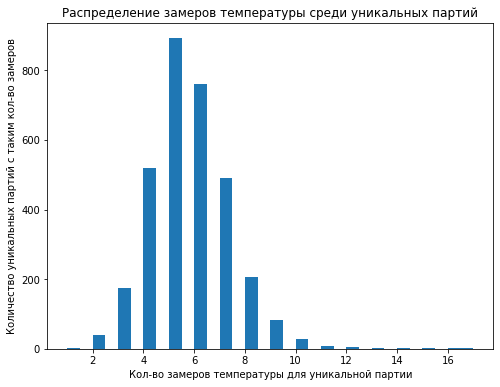

In [ ]:
plt.figure(figsize=(8, 6))
plt.hist(df_dict['temp']['key'].value_counts(), bins=32)
plt.xlabel('Кол-во замеров температуры для уникальной партии')
plt.ylabel('Количество уникальных партий с таким кол-во замеров')
plt.title('Распределение замеров температуры среди уникальных партий')
plt.show()

**Видим, что наибольшее кол-во партий имеют среди всех данных по 5 замеров температуры.**

**Промежуточные выводы по данным в датафрейме 'temp', содержащем данные об измерении температуры.**

* В данных этого датафрейма порядка 19% пропусков.
* В данных по температуре всего 746 уникальных партий, требующих исключение из последующего анализа по причинам: пропуска в данных, единственного замера, значения темп. ниже темп. плавления стали.
* Чаще всего в данных встречается по 5 замеров температуры для каждой уникальной партии.
* Количество партий 3241, но они не все представлены в этом датафрейме, нет данных о 25 уникальных партиях.
* Необходимо привести названия признаков к "змеиному" регистру и на англ.
* Необходимо изменить тип признака "Время замеры" на datetime, т.к. он отвечают за дату и время.
* Использовать в качестве признака необходимо только первый замер температуры, а в качестве целевого признака - последний замер температуры для уникальной партии.

### 2.6 Данные о проволочных материалах (объем)

In [ ]:
info_func(df_dict['wire'], 'wire')

Кол-во пропусков в долях в датафрейме "wire" 

           Null%  Total  Total_Null     Type
key     0.000000   3081           0    int64
Wire 1  0.008439   3081          26  float64
Wire 2  0.649789   3081        2002  float64
Wire 3  0.979552   3081        3018  float64
Wire 4  0.995456   3081        3067  float64
Wire 5  0.999675   3081        3080  float64
Wire 6  0.976306   3081        3008  float64
Wire 7  0.996430   3081        3070  float64
Wire 8  0.993833   3081        3062  float64
Wire 9  0.990587   3081        3052  float64


Первые 5 строк в датафрейме "wire" 
 
    key     Wire 1   Wire 2  Wire 3  Wire 4  Wire 5  Wire 6  Wire 7  Wire 8  \
0    1  60.059998      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1    2  96.052315      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2    3  91.160157      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3    4  89.063515      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4    5  89.238236  9.11456 

**Визуализируем кол-во действительных объектов в каждом из признаков**

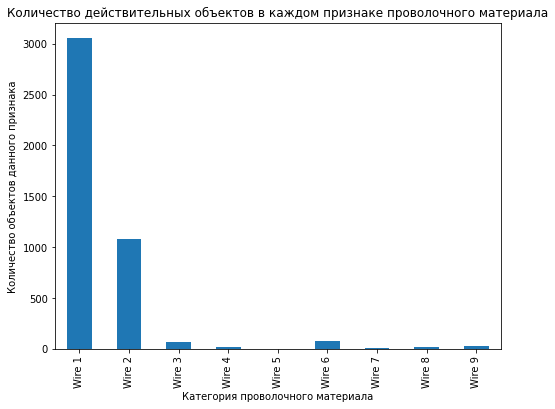

In [ ]:
plt.figure(figsize=(8, 6))
ax = df_dict['wire'].drop('key', axis=1).notnull().sum().plot(kind='bar')
ax.set_title('Количество действительных объектов в каждом признаке проволочного материала')
ax.set_xlabel('Категория проволочного материала')
ax.set_ylabel('Количество объектов данного признака')
plt.show()

In [ ]:
wires_to_del = df_dict['wire'].drop('key', axis=1) \
                    .notnull().sum().sort_values() \
                    .iloc[0:5].index.to_list()
print(f'Список категорий проволочных материалов для последующего удаления: \n{wires_to_del}')

Список категорий проволочных материалов для последующего удаления: 
['Wire 5', 'Wire 7', 'Wire 4', 'Wire 8', 'Wire 9']


**Видим, что кол-во действительных объектов очень мало в категориях 4, 5, 7, 8, 9. Вероятнее всего для получения лучших результатов при моделировании необходимо будет исключить данные признаки в следующем разделе.**


**В данных этого датафрейма наблюдается очень большое количество пропусков, вероятнее всего данный факт может быть обусловлен спецификой технологического процесса, т.к. не для всех партий добавляются все типы проволочных материалов. По этой причине логичнее всего пропуски в этих данных заполнить нулём. Сделаем это на следующем этапе предобработки данных.**

**Посмотрим на распределение данных в этом датафрейме по уникальным значениям номеров партий.**

In [ ]:
df_dict['wire']['key'].value_counts().unique()

array([1])

**Для каждой партии встречается всего одна строка данных.**

**Из предыдущего подраздела мы знаем, что кол-во уникальных партий равно как минимум 3241, а в данном датафрейме мы видим, что кол-во партий - 3081. Узнаем, какие партии отсутствуют
в этом датафрейме.**

In [ ]:
keys_not_in_wire = [x for x in list(range(1, 3242)) if x not in df_dict['wire']['key'].values]
print(f'Номера партий, отсутствующих в данных датафрейма "wire": {keys_not_in_wire}')
print(f'Количество партий, отсутствующих в данных датафрейма "wire": {len(keys_not_in_wire)}')

Номера партий, отсутствующих в данных датафрейма "wire": [41, 42, 51, 52, 53, 54, 55, 56, 81, 82, 83, 84, 85, 88, 109, 195, 197, 209, 210, 211, 212, 269, 330, 331, 332, 355, 375, 376, 377, 378, 382, 506, 529, 540, 607, 683, 710, 711, 712, 713, 714, 715, 744, 748, 754, 755, 766, 796, 797, 798, 799, 800, 841, 929, 930, 931, 932, 933, 934, 1102, 1103, 1104, 1105, 1106, 1107, 1133, 1184, 1300, 1379, 1380, 1437, 1525, 1526, 1527, 1528, 1564, 1565, 1566, 1646, 1743, 1744, 1745, 1746, 1747, 1748, 1758, 1817, 1818, 1836, 1946, 1977, 1978, 1979, 2010, 2031, 2043, 2103, 2195, 2196, 2197, 2198, 2214, 2215, 2216, 2217, 2218, 2219, 2236, 2238, 2278, 2356, 2360, 2367, 2368, 2369, 2370, 2373, 2388, 2389, 2390, 2391, 2392, 2393, 2446, 2469, 2491, 2624, 2625, 2626, 2627, 2628, 2629, 2683, 2788, 2789, 2790, 2791, 2792, 2814, 2815, 2846, 2847, 2848, 2849, 2850, 2863, 2871, 2872, 2873, 2874, 2875, 2876, 3035, 3036, 3037, 3038, 3039, 3040, 3200, 3207]
Количество партий, отсутствующих в данных датафрейма "w

**Промежуточные выводы по данным в датафрейме 'wire', содержащем данные о подаче проволочных материалов (объём).**

* В данных встречается только один набор значений для каждой уникальной партии.
* В этом датафрейме нет данных о 160 уникальных партиях.
* Необходимо привести названия признаков к "змеиному" регистру.
* В данных этого датафрейма наблюдается очень большое количество пропусков, вероятнее всего данный факт может быть обусловлен спецификой технологического процесса, логичнее всего пропуски в этих данных заполнить далее нулём.
* Кол-во действительных объектов очень мало в категориях 4, 5, 7, 8, 9 проволочных материалов. Вероятнее всего для получения лучших результатов при моделировании необходимо будет исключить данные признаки в следующем разделе.

### 2.7 Данные о проволочных материалах (время)

In [ ]:
info_func(df_dict['wire_time'], 'wire_time')

Кол-во пропусков в долях в датафрейме "wire_time" 

           Null%  Total  Total_Null    Type
key     0.000000   3081           0   int64
Wire 1  0.008439   3081          26  object
Wire 2  0.649789   3081        2002  object
Wire 3  0.979552   3081        3018  object
Wire 4  0.995456   3081        3067  object
Wire 5  0.999675   3081        3080  object
Wire 6  0.976306   3081        3008  object
Wire 7  0.996430   3081        3070  object
Wire 8  0.993833   3081        3062  object
Wire 9  0.990587   3081        3052  object


Первые 5 строк в датафрейме "wire_time" 
 
    key               Wire 1               Wire 2 Wire 3 Wire 4 Wire 5 Wire 6  \
0    1  2019-05-03 11:06:19                  NaN    NaN    NaN    NaN    NaN   
1    2  2019-05-03 11:36:50                  NaN    NaN    NaN    NaN    NaN   
2    3  2019-05-03 12:11:46                  NaN    NaN    NaN    NaN    NaN   
3    4  2019-05-03 12:43:22                  NaN    NaN    NaN    NaN    NaN   
4    5  2019-05-03

**В данных этого датафрейма наблюдается очень большое количество пропусков, аналогично предыдущему датафрейму.**

**Необходимо изменить тип данных на datetime, т.к. все данные признаки кроме значения номера партии отвечают за время и дату.**

**Необходимо привести к "змеиному" регистру названия признаков.**

**Посмотрим на распределение данных в этом датафрейме по уникальным значениям номеров партий.**

In [ ]:
df_dict['wire_time']['key'].value_counts().unique()

array([1])

**Для каждой партии встречается всего одна строка данных.**

**Из предыдущего подраздела мы знаем, что кол-во уникальных партий равно как минимум 3241, а в данном датафрейме мы видим, что кол-во партий - 3081. Узнаем, какие партии отсутствуют
в этом датафрейме.**

In [ ]:
keys_not_in_wire_time = [x for x in list(range(1, 3242)) if x not in df_dict['wire_time']['key'].values]
print(f'Номера партий, отсутствующих в данных датафрейма "wire_time": {keys_not_in_wire_time}')
print(f'Количество партий, отсутствующих в данных датафрейма "wire_time": {len(keys_not_in_wire_time)}')

Номера партий, отсутствующих в данных датафрейма "wire_time": [41, 42, 51, 52, 53, 54, 55, 56, 81, 82, 83, 84, 85, 88, 109, 195, 197, 209, 210, 211, 212, 269, 330, 331, 332, 355, 375, 376, 377, 378, 382, 506, 529, 540, 607, 683, 710, 711, 712, 713, 714, 715, 744, 748, 754, 755, 766, 796, 797, 798, 799, 800, 841, 929, 930, 931, 932, 933, 934, 1102, 1103, 1104, 1105, 1106, 1107, 1133, 1184, 1300, 1379, 1380, 1437, 1525, 1526, 1527, 1528, 1564, 1565, 1566, 1646, 1743, 1744, 1745, 1746, 1747, 1748, 1758, 1817, 1818, 1836, 1946, 1977, 1978, 1979, 2010, 2031, 2043, 2103, 2195, 2196, 2197, 2198, 2214, 2215, 2216, 2217, 2218, 2219, 2236, 2238, 2278, 2356, 2360, 2367, 2368, 2369, 2370, 2373, 2388, 2389, 2390, 2391, 2392, 2393, 2446, 2469, 2491, 2624, 2625, 2626, 2627, 2628, 2629, 2683, 2788, 2789, 2790, 2791, 2792, 2814, 2815, 2846, 2847, 2848, 2849, 2850, 2863, 2871, 2872, 2873, 2874, 2875, 2876, 3035, 3036, 3037, 3038, 3039, 3040, 3200, 3207]
Количество партий, отсутствующих в данных датафрей

**Промежуточные выводы по данным в датафрейме 'wire_time', содержащем данные о подаче проволочных материалов (время).**

* В данных встречается только один набор значений для каждой уникальной партии.
* В этом датафрейме нет данных о 160 уникальных партиях.
* Привести тип признаков, отвечающих за дату и время (все кроме key) к datetime.
* Необходимо привести названия признаков к "змеиному" регистру.
* В данных этого датафрейма наблюдается очень большое количество пропусков, вероятнее всего данный факт может быть обусловлен спецификой технологического процесса, логичнее всего пропуски в этих данных заполнить далее нулём, если будет принятно решение использовать эти данные.

### 2.8 Основные выводы раздела в ключе дальнейшего плана предобработки данных
* Не использовать данные о времени подачи сыпучих материалов и проволочных материалов, т.к. мы не используем временные ряды и влияние этих данных на целевой признак не может быть велико, ограничимся лишь данными об объемах данных двух типов материалов.
* Из всех далее используемых датафреймов удаляем данные, которые соответствуют номерам партий из сформированного списка для удаления, по причине аномальных значений и пропусков в температуре.
* По причине малого кол-ва действительных объектов исключаем из дальнейшего анализа признаки 4, 5, 7, 8, 9 проволочных материалов и 2, 7, 8, 9, 13 сыпучих материалов в следующем разделе.
* Пропуски в данных о подаче сыпучих и проволочных материалов заполняем 0.
* Необходимо изменить тип некоторых признаков и произвести переименование в соответствии со "змеиным" регистром на англ. языке.
* Создание новых признаков: активной энергии для каждой уникальной партии, а также суммарной мощности как активной, так и реактивной для каждой уникальной партии.
* Из данных по температуре использовать в качестве признака необходимо только первый замер температуры, а в качестве целевого признака - последний замер температуры для уникальной партии.
* Объединение данных будет происходить на основе признака key - номера партии.
* Вопросов к заказчику на текущий момент не возникло, вводные технологического процесса понятны.

## 3. Предобработка данных

### 3.1 Удаление данных, связанных с выбранными партиями

**Действуем исходя из основных выводов после исследования данных выше.**

**Создадим новый словарь датафреймов без двух датафреймов wire_time и bulk_time, т.к. мы исключаем их из дальнейшей работы. Удалим из данных датафреймов информацию о партиях, которые не пригодны для последующего анализа и моделирования.**

In [ ]:
#создаем новый словарь с фильтрованными датафреймами
df_dict_f = {key: value for key, value in df_dict.items() if key not in ['bulk_time', 'wire_time']}

#удаляем записи, связанные с отфильтрованными партиями
for key in df_dict_f:
    print(f'Размер датафрейма "{key}" до удаления партий: {df_dict[key].shape}')
    df_dict_f[key] = df_dict_f[key][~df_dict_f[key]['key'].isin(unique_keys_to_del)]
    print(f'Размер датафрейма "{key}" после удаления партий: {df_dict_f[key].shape} \n')
    print(f'Первые строки датафрейма "{key}" после удаления партий: \n{df_dict_f[key].head(2)}\n', '-'*75)

Размер датафрейма "arc" до удаления партий: (14876, 5)
Размер датафрейма "arc" после удаления партий: (11428, 5) 

Первые строки датафрейма "arc" после удаления партий: 
   key Начало нагрева дугой  Конец нагрева дугой  Активная мощность  \
0    1  2019-05-03 11:02:14  2019-05-03 11:06:02           0.305130   
1    1  2019-05-03 11:07:28  2019-05-03 11:10:33           0.765658   

   Реактивная мощность  
0             0.211253  
1             0.477438  
 ---------------------------------------------------------------------------
Размер датафрейма "bulk" до удаления партий: (3129, 16)
Размер датафрейма "bulk" после удаления партий: (2402, 16) 

Первые строки датафрейма "bulk" после удаления партий: 
   key  Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  \
0    1     NaN     NaN     NaN    43.0     NaN     NaN     NaN     NaN   
1    2     NaN     NaN     NaN    73.0     NaN     NaN     NaN     NaN   

   Bulk 9  Bulk 10  Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk 15  
0 

### 3.2 Удаление лишних признаков

**Исключим из датафреймов о сыпучих и проволочных материалах признаки, соответствующие выбранным категориям с малым количеством объектов.**

In [ ]:
def drop_col(key, list_col):
    print(f'Признаки в датафрейме "{key}" до удаления: \n{df_dict_f[key].columns.to_list()}\n')
    print(f'Размер датафрейма "{key}" до удаления: {df_dict_f[key].shape}')
    df_dict_f[key] = df_dict_f[key].drop(list_col, axis=1)
    print(f'Размер датафрейма "{key}" после удаления: {df_dict_f[key].shape} \n')
    print(f'Первые строки датафрейма "{key}" после удаления: \n{df_dict_f[key].head(2)}\n', '-'*75)
    return

drop_col('bulk', bulks_to_del)
drop_col('wire', wires_to_del)

Признаки в датафрейме "bulk" до удаления: 
['key', 'Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6', 'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12', 'Bulk 13', 'Bulk 14', 'Bulk 15']

Размер датафрейма "bulk" до удаления: (2402, 16)
Размер датафрейма "bulk" после удаления: (2402, 11) 

Первые строки датафрейма "bulk" после удаления: 
   key  Bulk 1  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 10  Bulk 11  Bulk 12  \
0    1     NaN     NaN    43.0     NaN     NaN      NaN      NaN    206.0   
1    2     NaN     NaN    73.0     NaN     NaN      NaN      NaN    206.0   

   Bulk 14  Bulk 15  
0    150.0    154.0  
1    149.0    154.0  
 ---------------------------------------------------------------------------
Признаки в датафрейме "wire" до удаления: 
['key', 'Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9']

Размер датафрейма "wire" до удаления: (2367, 10)
Размер датафрейма "wire" после удаления: (2367, 5) 

Первые строки датафре

### 3.3 Заполнение пропусков в данных

**Заполним теперь пропуски в данных о сыпучих и проволочных материалах нулевыми значениями.**

In [ ]:
for key in ['bulk', 'wire']:
    print(f'Суммарное кол-во пропусков во всех признаках '
          f'датафрейма "{key}" = {df_dict_f[key].isna().sum().sum()}')
    print(f'Размер датафрейма "{key}" до заполнения пропусков: {df_dict_f[key].shape} \n')
    df_dict_f[key] = df_dict_f[key].fillna(0)
    print(f'Суммарное кол-во пропусков во всех признаках датафрейма '
          f'"{key}" после заполнения пропусков = {df_dict_f[key].isna().sum().sum()}')
    print(f'Размер датафрейма "{key}" после заполнения пропусков: {df_dict_f[key].shape} \n')
    print(f'Первые строки датафрейма "{key}" после заполнения пропусков: \n{df_dict_f[key].head(2)}\n', '-'*75)

Суммарное кол-во пропусков во всех признаках датафрейма "bulk" = 15555
Размер датафрейма "bulk" до заполнения пропусков: (2402, 11) 

Суммарное кол-во пропусков во всех признаках датафрейма "bulk" после заполнения пропусков = 0
Размер датафрейма "bulk" после заполнения пропусков: (2402, 11) 

Первые строки датафрейма "bulk" после заполнения пропусков: 
   key  Bulk 1  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 10  Bulk 11  Bulk 12  \
0    1     0.0     0.0    43.0     0.0     0.0      0.0      0.0    206.0   
1    2     0.0     0.0    73.0     0.0     0.0      0.0      0.0    206.0   

   Bulk 14  Bulk 15  
0    150.0    154.0  
1    149.0    154.0  
 ---------------------------------------------------------------------------
Суммарное кол-во пропусков во всех признаках датафрейма "wire" = 6210
Размер датафрейма "wire" до заполнения пропусков: (2367, 5) 

Суммарное кол-во пропусков во всех признаках датафрейма "wire" после заполнения пропусков = 0
Размер датафрейма "wire" после заполнения пр

### 3.4 Переименования признаков

**Приведем названия признаков в соответствии со "змеиным" регистром на англ. языке.**

In [ ]:
print(f'Признаки в датафрейме "arc" до переименования: \n{df_dict_f["arc"].columns.to_list()}\n')
print(f'Размер датафрейма "arc" до заполнения пропусков: {df_dict_f["arc"].shape}')
df_dict_f['arc'] = df_dict_f['arc'].rename(columns={'Начало нагрева дугой': 'start_heat_time',
                                 'Конец нагрева дугой': 'end_heat_time',
                                 'Активная мощность': 'active_power',
                                 'Реактивная мощность': 'reactive_power'})
print(f'Размер датафрейма "arc" после переименования: {df_dict_f["arc"].shape} \n')
print(f'Первые строки датафрейма "arc" после переименования: \n{df_dict_f["arc"].head(2)}\n', '-'*75)

print(f'Признаки в датафрейме "gas" до переименования: \n{df_dict_f["gas"].columns.to_list()}\n')
print(f'Размер датафрейма "gas" до переименования: {df_dict_f["gas"].shape}')
df_dict_f['gas'] = df_dict_f['gas'].rename(columns={'Газ 1': 'gas1'})
print(f'Размер датафрейма "gas" после переименования: {df_dict_f["gas"].shape} \n')
print(f'Первые строки датафрейма "gas" после переименования: \n{df_dict_f["gas"].head(2)}\n', '-'*75)

print(f'Признаки в датафрейме "temp" до переименования: \n{df_dict_f["temp"].columns.to_list()}\n')
print(f'Размер датафрейма "temp" до переименования: {df_dict_f["temp"].shape}')
df_dict_f['temp'] = df_dict_f['temp'].rename(columns={'Время замера': 'meas_time',
                                 'Температура': 'temperature'})
print(f'Размер датафрейма "temp" после переименования: {df_dict_f["temp"].shape} \n')
print(f'Первые строки датафрейма "temp" после переименования: \n{df_dict_f["temp"].head(2)}\n', '-'*75)

def ren_col_del_space(key):
    col_dict = {}
    for col in df_dict_f[key].columns.to_list():
        col_dict[col] = "".join(col.split()).lower()
    print(f'Признаки в датафрейме "{key}" до переименования: \n{df_dict_f[key].columns.to_list()}\n')
    print(f'Размер датафрейма "{key}" до переименования: {df_dict_f[key].shape}')
    df_dict_f[key] = df_dict_f[key].rename(columns=col_dict)
    print(f'Размер датафрейма "{key}" после переименования: {df_dict_f[key].shape} \n')
    print(f'Первые строки датафрейма "{key}" после переименования: \n{df_dict_f[key].head(2)}\n', '-'*75)
    return

ren_col_del_space('bulk')
ren_col_del_space('wire')

Признаки в датафрейме "arc" до переименования: 
['key', 'Начало нагрева дугой', 'Конец нагрева дугой', 'Активная мощность', 'Реактивная мощность']

Размер датафрейма "arc" до заполнения пропусков: (11428, 5)
Размер датафрейма "arc" после переименования: (11428, 5) 

Первые строки датафрейма "arc" после переименования: 
   key      start_heat_time        end_heat_time  active_power  reactive_power
0    1  2019-05-03 11:02:14  2019-05-03 11:06:02      0.305130        0.211253
1    1  2019-05-03 11:07:28  2019-05-03 11:10:33      0.765658        0.477438
 ---------------------------------------------------------------------------
Признаки в датафрейме "gas" до переименования: 
['key', 'Газ 1']

Размер датафрейма "gas" до переименования: (2493, 2)
Размер датафрейма "gas" после переименования: (2493, 2) 

Первые строки датафрейма "gas" после переименования: 
   key       gas1
0    1  29.749986
1    2  12.555561
 ---------------------------------------------------------------------------
При

### 3.5 Приведение типов данных к корректным

**Проведем соответствующие изменения типов данных в ряде датафреймов.**

In [ ]:
def col_to_datetime(key, col_list):
    if isinstance(col_list, str):
        col_list = [col_list]
    for col in col_list:
        df_dict_f[key][col] = pd.to_datetime(df_dict_f[key].copy()[col])
    print(f'Размер датафрейма "{key}" до изменения типов: {df_dict_f[key].shape}')
    print(f'Размер датафрейма "{key}" после изменения типов: {df_dict_f[key].shape} \n')
    print(f'Типы признаков в датафрейме "{key}" после обновления: \n{df_dict_f[key].dtypes}\n')
    print(f'Первые строки датафрейма "{key}" после изменения типов: \n{df_dict_f[key].head(2)}\n', '-'*75)
    return

col_to_datetime('arc', ['start_heat_time', 'end_heat_time'])
col_to_datetime('temp', 'meas_time')

Размер датафрейма "arc" до изменения типов: (11428, 5)
Размер датафрейма "arc" после изменения типов: (11428, 5) 

Типы признаков в датафрейме "arc" после обновления: 
key                         int64
start_heat_time    datetime64[ns]
end_heat_time      datetime64[ns]
active_power              float64
reactive_power            float64
dtype: object

Первые строки датафрейма "arc" после изменения типов: 
   key     start_heat_time       end_heat_time  active_power  reactive_power
0    1 2019-05-03 11:02:14 2019-05-03 11:06:02      0.305130        0.211253
1    1 2019-05-03 11:07:28 2019-05-03 11:10:33      0.765658        0.477438
 ---------------------------------------------------------------------------
Размер датафрейма "temp" до изменения типов: (13898, 3)
Размер датафрейма "temp" после изменения типов: (13898, 3) 

Типы признаков в датафрейме "temp" после обновления: 
key                     int64
meas_time      datetime64[ns]
temperature           float64
dtype: object

Первые с

### 3.6 Создание новых признаков

**После применения всех изменений будем работать с датафреймом "arc", а именно: создадим новые признаки - суммарную затраченную активную энергию для каждой уникальной партии, а также суммарную мощность активную и реактивную для каждой уникальной партии.**

**Очевидно, что для нагрева стали в ковше указанные значения мощности измеряются в МВт, соответственно, получаемая активная энергия путем умножения активной мощности на дельту времени в секундах будет выражаться в МДж.**

In [ ]:
#создаем новую переменную - дельта по времени
df_dict_f['arc']['delta_time'] = df_dict_f['arc']['end_heat_time'] - df_dict_f['arc']['start_heat_time']

#создаем новую переменную - дельта времени в секундах
df_dict_f['arc']['seconds'] = (df_dict_f['arc']['delta_time'].astype(int) / 10**9).astype(int)

# создаем новую переменную - активная энергия в МДж
df_dict_f['arc']['active_energy'] = df_dict_f['arc']['active_power'] * df_dict_f['arc']['seconds']

# группируем по номеру партии и находим суммарные значение активной и реактивной мощности,
#а также активной энергии для каждой уникальной партии
df_dict_f['arc_new'] = df_dict_f['arc'].copy()[['key', 'active_power', 'reactive_power', 'active_energy']] \
      .groupby('key').sum().reset_index()
print(f'Размер датафрейма "arc" до агрегации данных: {df_dict_f["arc"].shape} \n')
print(f'Размер датафрейма "arc_new" после агрегации данных: {df_dict_f["arc_new"].shape} \n')
print(f'Первые строки датафрейма "arc_new" после агрегации данных: \n{df_dict_f["arc_new"].head(3)}')

Размер датафрейма "arc" до агрегации данных: (11428, 8) 

Размер датафрейма "arc_new" после агрегации данных: (2470, 4) 

Первые строки датафрейма "arc_new" после агрегации данных: 
   key  active_power  reactive_power  active_energy
0    1      3.036730        2.142821     628.616930
1    2      2.139408        1.453357     395.281800
2    3      4.063641        2.937457     581.774624


**Из датафрейма с данными по температуре использовать в качестве признака необходимо только первый замер температуры, а в качестве целевого признака - последний замер температуры для уникальной партии. Создадим новый датафрейм с агрегированными данными.**

**Сначала проверим, нету ли дублирующих значений времени и даты в данных.**

In [ ]:
print(f'Кол-во дубликатов в признаке "meas_time" = {df_dict_f["temp"]["meas_time"].duplicated().sum()}')

Кол-во дубликатов в признаке "meas_time" = 0


In [ ]:
#группируем по номеру партии и применяем к признаку время измерения функции минимум и максимум,
#удаляем признак номера партии, т.к потом будет объединять с исходных датафреймом, что не повторять признак key
df_gr = df_dict_f['temp'].copy().groupby('key')['meas_time'].agg(['min', 'max']).reset_index().drop('key', axis=1)

#объединяем по метке дата/время, т.к дубликатов в этом признаке нет
temp_x = pd.merge(df_dict_f['temp'], df_gr, left_on='meas_time', right_on='min')
temp_y = pd.merge(df_dict_f['temp'], df_gr, left_on='meas_time', right_on='max')

#объединяем в единый новый датафрейм, где temp_x - признак, а temp_y - целевой признак
df_dict_f['temp_new'] = pd.merge(temp_x, temp_y, on='key')[['key','temperature_x', 'temperature_y']]

print(f'Размер нового полученного датафрейма "temp_new": {df_dict_f["temp_new"].shape}\n')
print(f'Первые 2 строки датафрейма "temp_new": \n{df_dict_f["temp_new"].head(2)}\n')
print(f'Первые 7 строк датафрейма "temp": \n{df_dict_f["temp"].head(7)}\n')

Размер нового полученного датафрейма "temp_new": (2470, 3)

Первые 2 строки датафрейма "temp_new": 
   key  temperature_x  temperature_y
0    1         1571.0         1613.0
1    2         1581.0         1602.0

Первые 7 строк датафрейма "temp": 
   key           meas_time  temperature
0    1 2019-05-03 11:02:04       1571.0
1    1 2019-05-03 11:07:18       1604.0
2    1 2019-05-03 11:11:34       1618.0
3    1 2019-05-03 11:18:04       1601.0
4    1 2019-05-03 11:25:59       1606.0
5    1 2019-05-03 11:30:38       1613.0
6    2 2019-05-03 11:34:04       1581.0



**По первой партии можно видеть, что агрегация данных выполнена корректно.**

**В созданном новом датафрейме 'temp_new': temperature_x - признак, temperature_y - целевой признак.**

**Объединим теперь все новые датафреймы в единый общий, объединение будем делать по номеру партии - признак key.**

### 3.7 Создание новых агрегированных датафреймов и их анализ

In [ ]:
#создадим теперь список с именами датафреймов, которые будем далее объединять
list_keys = [x for x in list(df_dict_f) if x not in ['arc', 'temp', 'bulk']]

#создаем новый датафрейм, с которым далее будем объединять все остальные
df = df_dict_f['bulk']

for key in list_keys:
    df = df.merge(df_dict_f[key], on='key')

#из итогового датафрейма удаляем номер партии, т.к теперь он бесполезен и нужен был лишь для формирования итогового дф
df = df.drop('key', axis=1)

print(f'Размер итогового датафрейма "df": {df.shape}')
print(f'Информация об итоговом датафрейме "df", который будем использовать для моделирования: \n')
df.info()

Размер итогового датафрейма "df": (2324, 20)
Информация об итоговом датафрейме "df", который будем использовать для моделирования: 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2324 entries, 0 to 2323
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bulk1           2324 non-null   float64
 1   bulk3           2324 non-null   float64
 2   bulk4           2324 non-null   float64
 3   bulk5           2324 non-null   float64
 4   bulk6           2324 non-null   float64
 5   bulk10          2324 non-null   float64
 6   bulk11          2324 non-null   float64
 7   bulk12          2324 non-null   float64
 8   bulk14          2324 non-null   float64
 9   bulk15          2324 non-null   float64
 10  gas1            2324 non-null   float64
 11  wire1           2324 non-null   float64
 12  wire2           2324 non-null   float64
 13  wire3           2324 non-null   float64
 14  wire6           2324 non-null   flo

In [ ]:
print('Выведем описательные статистики для объединенного датафрейма:')
df.describe()

Выведем описательные статистики для объединенного датафрейма:


,bulk1,bulk3,bulk4,bulk5,bulk6,bulk10,bulk11,bulk12,bulk14,bulk15,gas1,wire1,wire2,wire3,wire6,active_power,reactive_power,active_energy,temperature_x,temperature_y
count,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000
mean,3.435026,47.317126,37.347676,2.645869,22.419535,5.063683,4.254303,208.597676,153.952668,120.078313,11.378854,102.423900,17.613213,3.241876,0.980926,3.126327,2.301280,539.381127,1587.368761,1593.372633
std,12.424463,75.238050,58.677890,22.426054,55.792509,20.938984,22.538843,157.112117,81.410544,84.655967,6.397008,43.540975,33.648176,27.972523,8.702531,1.220484,0.903711,257.301093,23.627590,11.207457
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008399,0.000000,0.000000,0.000000,0.000000,0.267676,0.196228,26.187544,1519.000000,1541.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,105.000000,105.000000,0.000000,7.282534,73.204559,0.000000,0.000000,0.000000,2.295960,1.671099,368.304687,1571.000000,1587.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,149.000000,107.000000,10.100687,101.103600,0.000000,0.000000,0.000000,3.036516,2.225900,508.538758,1587.000000,1593.000000
75%,0.000000,80.000000,77.250000,0.000000,0.000000,0.000000,0.000000,283.000000,204.000000,204.000000,14.218487,128.075222,23.102560,0.000000,0.000000,3.834302,2.829180,679.198658,1603.000000,1598.000000
max,185.000000,454.000000,281.000000,603.000000,503.000000,159.000000,313.000000,1849.000000,636.000000,405.000000,77.995040,330.314424,282.780152,385.008668,180.454575,12.375636,8.949049,3718.054401,1660.000000,1653.000000


In [ ]:
print(f'Первые строки объединенного датафрейма "df": \n{df.head()}')

Первые строки объединенного датафрейма "df": 
   bulk1  bulk3  bulk4  bulk5  bulk6  bulk10  bulk11  bulk12  bulk14  bulk15  \
0    0.0    0.0   43.0    0.0    0.0     0.0     0.0   206.0   150.0   154.0   
1    0.0    0.0   73.0    0.0    0.0     0.0     0.0   206.0   149.0   154.0   
2    0.0    0.0   34.0    0.0    0.0     0.0     0.0   205.0   152.0   153.0   
3    0.0    0.0   81.0    0.0    0.0     0.0     0.0   207.0   153.0   154.0   
4    0.0    0.0   78.0    0.0    0.0     0.0     0.0   203.0   151.0   152.0   

        gas1      wire1    wire2  wire3  wire6  active_power  reactive_power  \
0  29.749986  60.059998  0.00000    0.0    0.0      3.036730        2.142821   
1  12.555561  96.052315  0.00000    0.0    0.0      2.139408        1.453357   
2  28.554793  91.160157  0.00000    0.0    0.0      4.063641        2.937457   
3  18.841219  89.063515  0.00000    0.0    0.0      2.706489        2.056992   
4   5.413692  89.238236  9.11456    0.0    0.0      2.252950        1.687

**Пропусков в данных нет, все данные выглядят корректно.**

**В итоге получили 19 признаков и 1 целевой признак.**

**Кол-во объектов для моделирования = 2324, что совсем немного, на фоне небольшого количества объектов может быть получен не очень хороший результат предсказаний, проверим далее.**

**Значения признаков очень сильно отличаются друг от друга, для получения хорошего результата при использовании линейной регрессии необходимо будет масштабировать данные признаки.**

**Выведем данные о корреляции признаков в итоговом датафрейме.**

In [ ]:
df.corr()

,bulk1,bulk3,bulk4,bulk5,bulk6,bulk10,bulk11,bulk12,bulk14,bulk15,gas1,wire1,wire2,wire3,wire6,active_power,reactive_power,active_energy,temperature_x,temperature_y
bulk1,1.000000,-0.011538,0.041662,0.060365,-0.003581,-0.023333,-0.038008,0.325724,0.207606,-0.001211,0.234089,0.013823,-0.009261,0.020204,0.148509,0.099145,0.095677,0.095641,0.079098,-0.075428
bulk3,-0.011538,1.000000,-0.295526,-0.006766,0.066316,-0.085266,-0.007383,0.018059,0.011209,-0.013181,0.059665,0.037788,0.094897,0.005840,0.007174,0.101267,0.099018,0.088805,-0.113380,-0.037156
bulk4,0.041662,-0.295526,1.000000,0.028273,-0.251577,-0.084975,-0.119733,0.105190,-0.091103,0.100833,0.017532,0.298145,-0.268115,-0.039326,-0.011507,0.005013,0.004137,-0.020899,0.165484,0.187817
bulk5,0.060365,-0.006766,0.028273,1.000000,-0.021853,-0.028544,-0.015888,-0.072951,-0.066101,-0.067426,0.086869,-0.013454,-0.013811,0.070889,0.204796,0.073228,0.072459,0.019551,0.078729,-0.028446
bulk6,-0.003581,0.066316,-0.251577,-0.021853,1.000000,-0.097218,0.196983,-0.112169,0.176791,-0.108626,0.139574,-0.235445,0.205432,-0.046545,-0.020223,0.133855,0.133025,0.148159,-0.127046,-0.180906
bulk10,-0.023333,-0.085266,-0.084975,-0.028544,-0.097218,1.000000,-0.045666,0.027651,-0.045880,0.051953,-0.008634,0.062892,-0.103828,-0.028039,-0.017860,0.010281,0.008439,-0.007075,0.035789,0.061227
bulk11,-0.038008,-0.007383,-0.119733,-0.015888,0.196983,-0.045666,1.000000,-0.040419,0.077966,-0.048571,0.041945,-0.117798,0.062074,-0.021878,0.008655,0.065809,0.064032,0.068808,-0.110430,-0.114936
bulk12,0.325724,0.018059,0.105190,-0.072951,-0.112169,0.027651,-0.040419,1.000000,0.481609,0.613870,0.216969,0.170812,-0.098208,-0.120697,-0.042895,0.285153,0.284874,0.421033,-0.079574,0.266805
bulk14,0.207606,0.011209,-0.091103,-0.066101,0.176791,-0.045880,0.077966,0.481609,1.000000,0.264903,0.268284,-0.052654,0.037017,-0.009010,-0.052578,0.299659,0.295609,0.406902,-0.179991,0.114893
bulk15,-0.001211,-0.013181,0.100833,-0.067426,-0.108626,0.051953,-0.048571,0.613870,0.264903,1.000000,0.043033,0.119047,-0.096411,-0.118355,-0.032618,0.168583,0.166967,0.272895,-0.062382,0.265772


**Количество признаков в данных достаточно велико, поэтому информация о корреляции несчитываема, исправим это, создав словарь, в котором ключом будет каждый из признаков, а ключу соответствовать таблица с топовыми признаками по модулю значения корреляции с признаком-ключом и значение данной корреляции без модуля.**

In [ ]:
data_corr = df.corr() #матрица корреляции по данным в df
col_list = data_corr.columns.to_list()
dict_top_corr_data = {} #словарь с ключами по названию параметров с содержанием топовых корреляций с др. параметрами

for column in data_corr.columns: # цикл по столбцам в матрице корреляции по данным в df
    #делаем датафрейм из одного столбца, значения корр. берем по модулю, чтобы проще было сравнивать и удаляем строку
    #с тем же параметром, т.к. там корреляция = 1
    column_corr = data_corr[column].to_frame().drop(column)
    column_corr_abs = column_corr.abs()
    #выбираем индексы тех значений, где удовлетворяется условие
    index_top = column_corr_abs[(column_corr_abs[column] >= 0.15)].index
    #сохраняем в словарь топовые корреляции для данного параметра
    dict_top_corr_data[column] = column_corr.loc[index_top]

print('Признаки с высокими значениями корреляции, не менее 0.4:')
for key in col_list:
    if dict_top_corr_data[key][dict_top_corr_data[key][key] >= 0.4].size != 0:
        print(dict_top_corr_data[key][dict_top_corr_data[key][key] >= 0.4], '\n')

Признаки с высокими значениями корреляции, не менее 0.4:
                 bulk12
bulk14         0.481609
bulk15         0.613870
active_energy  0.421033 

                 bulk14
bulk12         0.481609
active_energy  0.406902 

         bulk15
bulk12  0.61387 

                active_power
reactive_power      0.992416
active_energy       0.818748 

               reactive_power
active_power         0.992416
active_energy        0.811139 

                active_energy
bulk12               0.421033
bulk14               0.406902
active_power         0.818748
reactive_power       0.811139 



**Видим, что между признаками, отвечающими за активную и реактивную мощности, а также активную энергию наблюдается высокая линейная корреляция. Для корректного обучения линейной регрессии нам необходимо будет не использовать признаки с высокой корреляцией, т.к. это может привести к мультиколлинеарности. Необходимо определить, какие из данных признаков имеют бОльшее влияние на целевой признак и оставить только тот признак, который наибольшим образом коррелирует с целевым признаком. Посмотрим значения корреляции с целевым признаком.**

In [ ]:
print('Значения корреляции целевого признака и других признаков:')
dict_top_corr_data['temperature_y']['temperature_y'].sort_values(ascending=False)

Значения корреляции целевого признака и других признаков:


wire1             0.317488
temperature_x     0.301882
bulk12            0.266805
bulk15            0.265772
active_energy     0.257862
bulk4             0.187817
active_power      0.176486
reactive_power    0.171078
bulk6            -0.180906
wire2            -0.207242
Name: temperature_y, dtype: float64

**Видим, что бОльшая корреляция между целевым признаком и признаками, связанными с мощностью и энергией, - у признака активная энергия. Его мы из трех и оставим для моделирования с помощью линейной регрессии.**

**Отфильтруем итоговый датафрейм для линейной регрессии.**

In [ ]:
df_linreg = df.drop(['active_power', 'reactive_power'], axis=1)
df_linreg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2324 entries, 0 to 2323
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   bulk1          2324 non-null   float64
 1   bulk3          2324 non-null   float64
 2   bulk4          2324 non-null   float64
 3   bulk5          2324 non-null   float64
 4   bulk6          2324 non-null   float64
 5   bulk10         2324 non-null   float64
 6   bulk11         2324 non-null   float64
 7   bulk12         2324 non-null   float64
 8   bulk14         2324 non-null   float64
 9   bulk15         2324 non-null   float64
 10  gas1           2324 non-null   float64
 11  wire1          2324 non-null   float64
 12  wire2          2324 non-null   float64
 13  wire3          2324 non-null   float64
 14  wire6          2324 non-null   float64
 15  active_energy  2324 non-null   float64
 16  temperature_x  2324 non-null   float64
 17  temperature_y  2324 non-null   float64
dtypes: float

**Посмотрим распределение данных в целевом признаке.**

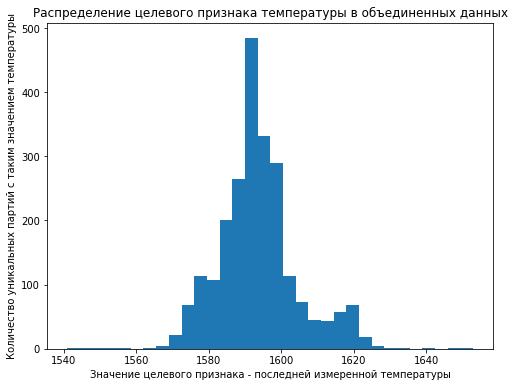

In [ ]:
plt.figure(figsize=(8, 6))
plt.hist(df['temperature_y'], bins=32)
plt.xlabel('Значение целевого признака - последней измеренной температуры')
plt.ylabel('Количество уникальных партий с таким значением температуры')
plt.title('Распределение целевого признака температуры в объединенных данных')
plt.show()

**Распределение целевого признака нормальное, без аномальных выбросов.**

### 3.8 Основные выводы раздела
* Из итогового датафрейма были исключены данные о времени подачи сыпучих материалов и проволочных материалов, т.к. мы не используем временные ряды и влияние этих данных на целевой признак не может быть велико.
* Из итогового датафрейма исключили данные, которые относятся к номерам партий из сформированного ранее списка для удаления, по причине аномальных значений, пропусков в температуре и единственного замера температуры.
* Из итогового датафрейма исключили признаки 4, 5, 7, 8, 9 проволочных материалов и 2, 7, 8, 9, 13 сыпучих материалов по причине малого кол-ва действительных объектов.
* Пропуски в данных о подаче сыпучих и проволочных материалов заполнили значением 0.
* Изменили тип признаков, отвечающих за дату и время, на datatime в данных по измерению температуры и электродах для последующей агрегации данных и получения нового признака.
* Произвели переименование всех признаков в соответствии со "змеиным" регистром на англ. языке.
* Созданы новые признаки: суммарная активная энергии для каждой уникальной партии (произведение времени выделения активной мощности на ее значение), а также суммарной активной мощности и суммарной реактивной мощности для каждой уникальной партии.
* Из данных по температуре получен признак - первый замер температуры для уникальной партии, а в качестве целевого признака - последний замер температуры для уникальной партии.
* Объединение данных в итоговый датафрейм происходило на основе признака key - номера партии.
* В объединенном датафрейме пропусков в данных нет, все данные выглядят корректно.
* Кол-во объектов для моделирования = 2324, что совсем немного, на фоне небольшого количества объектов может быть получен не очень хороший результат предсказаний, проверим далее.
* Значения признаков очень сильно отличаются друг от друга, для получения хорошего результата при использовании линейной регрессии необходимо будет нормализовать данные признаки в следующем разделе.
* Между признаками, отвечающими за активную и реактивную мощности, а также активную энергию наблюдается высокая линейная корреляция (выше 0.8). Для исключения мультиколлинеарности оставили из данных трех признаков только признак активная энергия для выборки, с которой будем работать с линейной регрессией (df_linreg), ввиду наибольшей корреляции его с целевым признаком.
* В итоге получили для бустинговой модели выборку (df) с 19 признаками и 1 целевым признаком. Для линейной регрессии - выборку (df_linreg) с 17 признаками и 1 целевым признаком. Целевой признак - temperature_y.

## 4. Машинное обучение

**Будем использовать для моделирования две модели - линейную регрессию и бустинговую модель - CatBoost.**

### 4.1 Линейная регрессия

**Как было отмечено ранее, линейная регрессия особо чувствительна к ненормализованным признакам. Поэтому план такой:**

* Делим объединенные данные для линейной регрессии на два датасета - с признаками и с целевым признаком.
* Делим выборки на тренировочную и тестовую в соотношении 75% и 25%, используем значение random_state = SEED.
* Применяем нормализацию признаков с помощью MinMaxScaler.
* С помощью cross_validate вычисляем MAE для линейной регрессии с 5 фолдами.
* Определяем лучшее значение MAE на тренировочной выборке для линейной регрессии.
* Определеям время обучения и время предсказания линейной регрессии.

In [ ]:
X_linreg = df_linreg.drop('temperature_y', axis=1)
y_linreg = df_linreg['temperature_y']
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X_linreg,
                                                                y_linreg,
                                                                test_size=0.25,
                                                                shuffle=True,
                                                                random_state=SEED)
scaler = MinMaxScaler()
X_train_lr_scaled = scaler.fit_transform(X_train_lr)
X_test_lr_scaled = scaler.transform(X_test_lr)
model_lr = LinearRegression()

cv_linreg = cross_validate(
                model_lr,
                X_train_lr_scaled,
                y_train_lr,
                scoring='neg_mean_absolute_error',
                cv=5)

linreg_mae_train = round(-1*max(cv_linreg['test_score']), 2)
linreg_fit_time_train = round(cv_linreg['fit_time'].mean(), 5)
linreg_score_time_train = round(cv_linreg['score_time'].mean(), 5)
print('Лучшее значение MAE для LinReg на тренировочной выборке =', linreg_mae_train)
print('Усредненное время обучения LinReg на тренировочной выборке =', linreg_fit_time_train)
print('Усредненное время предсказания LinReg на тренировочной выборке =', linreg_score_time_train)

Лучшее значение MAE для LinReg на тренировочной выборке = 6.29
Усредненное время обучения LinReg на тренировочной выборке = 0.00277
Усредненное время предсказания LinReg на тренировочной выборке = 0.00055


### 4.2 Бустинговая модель CatBoost

**План для бустинговой модели такой:**

* Делим объединенные данные на два датасета - с признаками и с целевым признаком.
* Делим выборки на тренировочную и тестовую в соотношении 75% и 25%, используем значение random_state = SEED.
* Задаем диапазоны значений гиперпараметров, который будем перебирать в GridSearchCV.
* Используем GridSearchCV для поиска наилучшей комбинации гиперпараметров CatBoostRegressor, дающих наилучшее MAE на тренировочной выборке. Фиксируем модель с наилучшей комбинацией гиперпараметров.
* Определяем лучшее значение MAE на тренировочной выборке для линейной регрессии.
* Определеям время обучения и время предсказания линейной регрессии.

In [ ]:
X_cbr = df.drop('temperature_y', axis=1)
y_cbr = df['temperature_y']
X_train_cbr, X_test_cbr, y_train_cbr, y_test_cbr = train_test_split(X_cbr,
                                                                    y_cbr,
                                                                    test_size=0.25,
                                                                    shuffle=True,
                                                                    random_state=SEED)

model_cbr = CatBoostRegressor(random_state=SEED, silent=True)
param_cbr = {'learning_rate': [0.1, 0.01, 1],
             'depth': [4, 6, 8, 10],
             'n_estimators': [100, 200]}
grid_cbr = GridSearchCV(estimator=model_cbr,
                        param_grid=param_cbr,
                        cv=5,
                        scoring='neg_mean_absolute_error')
grid_cbr.fit(X_train_cbr, y_train_cbr)
best_model_cbr = grid_cbr.best_estimator_
print(f'Лучшие гиперпараметры модели CBR: {grid_cbr.best_params_}')

cbr_mae_train = round(-1 * grid_cbr.best_score_, 2)
cbr_fit_time_train = round(
    pd.DataFrame(grid_cbr.cv_results_).iloc[grid_cbr.best_index_]['mean_fit_time'], 5)
cbr_score_time_train = round(
    pd.DataFrame(grid_cbr.cv_results_).iloc[grid_cbr.best_index_]['mean_score_time'], 5)
print(f'Лучшее значение метрики MAE для модели CBR на тренировочной выборке = {cbr_mae_train}')
print(f'Время обучения модели CBR с лучшим score на тренировочной выборке = {cbr_fit_time_train}')
print(f'Время предсказания CBR с лучшим score на тренировочной выборке = {cbr_score_time_train}')
best_model_cbr = grid_cbr.best_estimator_

Лучшие гиперпараметры модели CBR: {'depth': 8, 'learning_rate': 0.1, 'n_estimators': 100}
Лучшее значение метрики MAE для модели CBR на тренировочной выборке = 6.6
Время обучения модели CBR с лучшим score на тренировочной выборке = 1.72275
Время предсказания CBR с лучшим score на тренировочной выборке = 0.00219


**На тренировочных данных лучше всего себя показала линейная регрессия с результатом MAE = 6.29.**

**Результат метрики MAE у модели CatBoostRegressor составил 6.6.**

**При этом время обучения на тестовых данных у линейной регрессии значительно лучше, чем у модели CatBoostRegressor: 3.4 мс против 191 мс.**

**Соответственно, на тестовой выборке будем тестировать линейную регрессию.**

### 4.3 Проверка на тестовых данных модели линейной регрессии

In [ ]:
model_lr.fit(X_train_lr_scaled, y_train_lr)
pred_test_lr = model_lr.predict(X_test_lr_scaled)
print("MAE линейной регрессии на тестовой выборке: ", round(mean_absolute_error(y_test_lr, pred_test_lr),2))

MAE линейной регрессии на тестовой выборке:  6.66


**Полученное значение MAE удовлетворяет первичному условию задачи: MAE < 6.8.**

**Проверим теперь влияние признаков на предсказания модели линейной регрессии.**

**Положительные значения коэффициентов указывают на положительное влияние признака на целевую переменную, а отрицательные значения - на отрицательное влияние. Значения коэффициентов также указывают на силу влияния признака: чем больше по модулю значение коэффициента, тем сильнее влияние признака на предсказания модели.**

In [ ]:
coefficients = list(model_lr.coef_)
features = df_linreg.drop('temperature_y', axis=1).columns.to_list()
linreg_coef = pd.DataFrame({'features':features,
                            'coeff':coefficients,
                            'coeff_abs':[abs(x) for x in coefficients]})
print('Коэффициенты для каждого признака, отражающие влияние признака на предсказания модели линейной регрессии:')
linreg_coef.sort_values(by='coeff_abs', ascending=False)[['features', 'coeff']].head(10)

Коэффициенты для каждого признака, отражающие влияние признака на предсказания модели линейной регрессии:


,features,coeff
15,active_energy,32.677372
16,temperature_x,27.398625
0,bulk1,-26.017597
14,wire6,-18.903589
12,wire2,-13.483107
7,bulk12,11.879882
11,wire1,11.496942
3,bulk5,-10.020272
4,bulk6,-9.506221
10,gas1,-8.827962


**Видим, что наибольшее влияние на модель оказывают признаки:**
* Активная энергия - active_energy.
* Первая измеренная температура в ковше - temperature_x.
* Объем первой категории сыпучих материалов - bulk1.
* Объем шестой и второй категорий проволочных материалов - wire6 и wire2.

**Проверим теперь модель на адекватность с помощью константной модели.**

### 4.4 Проверка моделей на адекватность

**Проверим модели на адекватность с помощью Dummy Model из класса sklearn, предварительно импортировав ее в первом пункте.**

**Проверка состоит в том, чтобы качество выбранной выше обученной модели было выше, чем качество модели Dummy, которая предсказывает результат не опираясь на признаки тренировочной выборки.**

In [ ]:
model_dummy = DummyRegressor()
parameters_dummy = {'strategy':['mean', 'median', 'constant'],
                    'constant':(1580,1620,1)}
gridsearch_dummy = GridSearchCV(
    estimator=model_dummy,
    param_grid=parameters_dummy,
    scoring='neg_mean_absolute_error',
    cv=5, n_jobs=-1)
gridsearch_dummy.fit(X_train_cbr, y_train_cbr)
print('Лучшее значение метрики MAE для Dummy-модели на тренировочной выборке =',
      round((-1 * gridsearch_dummy.best_score_), 2))

Лучшее значение метрики MAE для Dummy-модели на тренировочной выборке = 8.13


In [ ]:
predict_dummy = gridsearch_dummy.best_estimator_.predict(X_test_cbr)
print('Лучшее значение метрики MAE для Dummy-модели на тестовой выборке =',
      round(mean_absolute_error(y_test_cbr, predict_dummy),2))

Лучшее значение метрики MAE для Dummy-модели на тестовой выборке = 7.88


**В итоге с помощью Dummy модели удалось получить наилучшее качество модели с MAE равным 7.88 на тестовой выборке, что ниже наилучшего результата выбранной и обученной модели линейной регрессии. Что доказывает адекватность найденной и выбранной нами модели.**

### 4.5 Основные выводы после раздела
* Объединенный итоговый датасет был разделен на две версии - одна для линейной регрессии, где были исключены два признака (активная мощность и реактивная мощность), имеющие возможность вызвать мультиколлинеарность и нарушить корректные результаты работы данной модели. Вторая версия - полная, для бустинговой модели CatBoostRegressor. В итоге для линейной регрессии выборка состояла из 17 признаков и 1 целевого признака. Для бустинговой модели CatBoostRegressor выборка состояла из 19 признаков и 1 целевого признака.
* Разделение выборок на обучающую и тестовую было в соотношении 75% и 25% по условию задачи с помощью train_test_split с указанием random_state = 220523 по условию задачи.
* Для выборки, с которой работала линейная регрессия, было дополнительно произведена стандартизация признаков с помощью MinMaxScaler(), т.к. модели данного типа чувствительны к большому разбросу значений в признаках.
* Использовалась кросс-валидация для оценки линейной регрессии с помощью cross_validate, кол-во фолдов бралось равное 5.
* С помощью линейной регрессии на обучающей выборке был получен наилучший результат метрики MAE равный 6.29, при этом время обучения составило 3.4 мс.
* С помощью бустинговой модели CatBoostRegressor на обучающей выборке был получен наилучший результат метрики MAE равный 6.6, при этом время обучения составило 191 мс. Комбинация гиперпараметров, с помощью которой был достигнут данный результат: 'depth' = 8, 'learning_rate' = 0.1, 'n_estimators' = 100, random_state = 220523.
* По результатам проверки на тренировочной выборке была выбрана модель линейной регрессии для предсказания на тестовой выборке.
* На тестовой выборке линейная регрессия показала результат метрики MAE равный 6.66, что удовлетворяет исходному условию задачи - получение MAE < 6.8.
* Было изучено влияние признаков на результат предсказания линейной регрессии. Наибольшее положительное влияние оказали признаки активная энергия (active_energy) и первое измеренное значение температуры в ковше (temperature_x).
* Была проведена проверка адекватности моделей с помощью константной модели DummyRegressor. С помощью данной модели удалось получить значение MAE на тренировочных данных 8.13, а на тестовых данных 7.88. Что хуже полученных результатов с помощью линейной регрессии и бустинговой модели, что доказывают адекватность выбранной нами модели линейной регрессии.

## 5. Отчет

### 5.1 Сравнение решения и плана

**Первоначальный план:**

* Не использовать данные о времени подачи сыпучих материалов и проволочных материалов, т.к. мы не используем временные ряды и влияние этих данных на целевой признак не может быть велико, ограничимся лишь данными об объемах данных двух типов материалов.
* Из всех далее используемых датафреймов удаляем данные, которые соответствуют номерам партий из сформированного списка для удаления, по причине аномальных значений, пропусков в температуре и единичных записей о температуре.
* По причине малого кол-ва действительных объектов исключаем из дальнейшего анализа признаки 4, 5, 7, 8, 9 проволочных материалов и 2, 7, 8, 9, 13 сыпучих материалов в следующем разделе.
* Пропуски в данных о подаче сыпучих и проволочных материалов заполняем 0.
* Необходимо изменить тип некоторых признаков и произвести переименование в соответствии со "змеиным" регистром на англ. языке.
* Создание новых признаков: активной энергии для каждой уникальной партии, а также суммарной мощности как активной, так и реактивной для каждой уникальной партии.
* Из данных по температуре использовать в качестве признака необходимо только первый замер температуры, а в качестве целевого признака - последний замер температуры для уникальной партии.
* Объединение данных будет происходить на основе признака key - уникального номера партии.
* Оценка нового агрегированного датасета на корреляцию между признаками и распределение целевого признака.
* Выбор двух моделей, одна из которых линейная, вторая - бустинговая.
* Разделение данных на тренировочную и тестовую выборки в соотношении 75 к 25.
* Стандартизация признаков для линейных моделей.
* Использование кросс-валидации и автоматизированного подбора гиперпараметров, где это применимо.
* Выбор лучшей модели на тренировочной выборке по метрике MAE.
* Тестирования лучшей модели на тестовой выборке.
* Оценка адекватности модели с точки зрения сравнения с метрикой MAE константной модели.

**Все основные пункты плана были выполнены.**


### 5.2 Описание трудностей проекта

**В целом особых трудностей не возникло. Основная трудность - это большой объем информации, подробный анализ и исследование ее.

### 5.3 Ключевые шаги решения задачи

* Обработка данных;
* Исследовательский анализ данных;
* Предобработка данных и получение агрегированного датасета;
* Разработка и выбор лучшей модели с последующей проверкой на тестовой выборке;
* Проверка выбранной модели на адекватность с помощью константной модели.
* Отчет.

### 5.4 Признаки, которые использовали для обучения и их обработка
* Итоговый агрегированный датафрейм состоит из 19 признаков, 1 целевого признака и 2324 записей.
* Обучающая и тестовая выборка разделены в соотношении 75% к 25%.
* 15 признаков основаны на объеме подаваемых сыпучих материалов и проволки, а также о кол-ве продувающего газа.
* 2 признака основаны на суммарных значениях активной и реактивной мощности для уникальной партии.
* 1 признак основан на суммарной активной энергии для уникальной партии, сгенерирован на основе суммы произведения активной мощности и времени ее выделения для каждого момента для уникальной партии.
* 1 признак - первая измеренная температура в ковше для уникальной партии
- 1 целевой признак - последняя измеренная температура в ковше для уникальной партии


### 5.5 Полное описание использованной модели
* Было обучено две модели - линейная регрессия и бустинговая модель CatBoostRegressor. Наилучший результат на обучающей выборке показала линейная регрессия, метрика MAE = 6.29, время обучения 3.4 мс.
* При этом наилучший результат бустинговой модели CatBoostRegressor на обучающей выборке: MAE = 6.6, время обучения 191 мс. Комбинация гиперпараметров, с помощью которой был достигнут данный результат: 'depth' = 8, 'learning_rate' = 0.1, 'n_estimators' = 100, random_state = 220523.
* Для тестовой выборки была выбрана линейная регрессия, которая показала результат метрики MAE равный 6.66, что удовлетворяет исходному условию задачи - получение MAE < 6.8.
* Была проведена проверка адекватности моделей с помощью константной модели DummyRegressor. С помощью данной модели удалось получить значение MAE на тренировочных данных 8.13, а на тестовых данных 7.88. Что хуже полученных результатов с помощью линейной регрессии и бустинговой модели, что доказывают адекватность выбранной нами модели линейной регрессии.

### 5.6 Итоговая метрика
* На тестовой выборке линейная регрессия показала результат MAE равный 6.66.

### 5.7 Рекомендации по улучшению решения
* Было представлено не очень большое количество данных для получения высокого результата работы бустинговой модели, можно было бы попробовать искусственым образом увеличить исходную выборку с помощью ресемплинга.
* Рассмотреть более широкий набор гиперпараметров в бустинговой модели. * Создать больше новых признаков.
* Оставить в выборке те признаки, которые имеют более высокие значения коэффициента влияния на предсказание целевой переменной для данной модели.